<a href="https://colab.research.google.com/github/maryamzamani11/Forecast_Temperature_Timeseries/blob/main/TF_CNN_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN is usually used for images, but here you will see we can use this technique for modelling and forecasting time series as well, in this case a time series with the shape TxD is the input of CNN. For univariate time series D=1. And convolution is one dimensional. Instead of using a 2-dimensional filter we use a 1dimensional filter size.**

I used cleaned temperature dataset in this notebook, to see how I cleaned the data please look at TF_ANN_Temperature.ipynb

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error

In [6]:
from google.colab import files
import io 
data = files.upload()

Saving temperature_clean.csv to temperature_clean (1).csv


In [9]:
df = pd.read_csv(io.BytesIO(data['temperature_clean.csv']),index_col='Date')

In [11]:
df.head(4)

,Region,Country,State,City,AvgTemperature
Date,,,,,
1995-01-01,North America,US,New York,New York City,44.0
1995-01-02,North America,US,New York,New York City,41.8
1995-01-03,North America,US,New York,New York City,28.1
1995-01-04,North America,US,New York,New York City,31.7


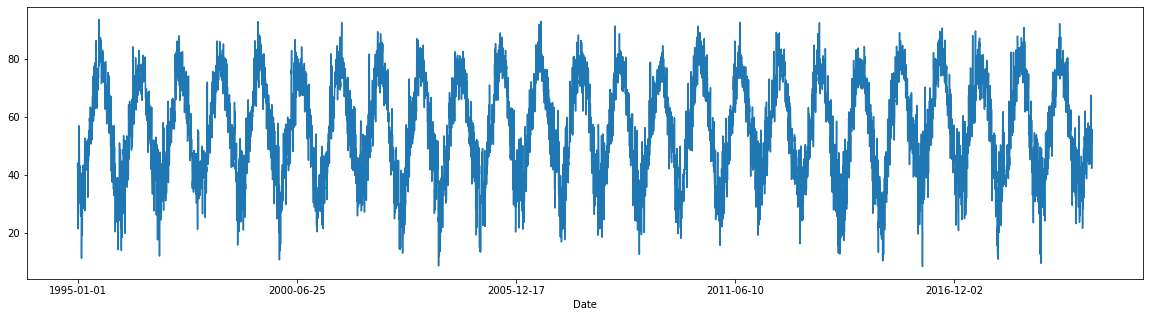

In [13]:
plt.figure(figsize=(20,5))
df['AvgTemperature'].plot()

Make the time series stationary using differencing. This way seasonality is removed, by subtracting the temperature value from the values of the same day in the last year.

In [16]:
df['Diff365'] = df['AvgTemperature'].diff(365) 

In [17]:
Temperature = df['Diff365'].dropna().to_numpy()

I make a supervised dataset. For that, I choose T=10 data points as features dimension and the next value after the 10 points as target. That means we use the temperature of the last 10 days to predict tomorrow's temperature.

In [26]:
T = 10
X = []
Y = []


for t in range(len(Temperature)-T):
    x = Temperature[t:t+T]
    X.append(x)
    y = Temperature[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T,1) # input data for CNN has the shape NxTxD, since the temperature time series is univariate D=1
Y = np.array(Y)
N = len(X)    # this is the number of samples in the supervised dataset   



In [27]:
# split train and test sets
Ntest = 10
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [30]:
# CNN model
# Number of conv layers is a hyperparameter and depends on the data and length of T.
i = Input(shape=(T,1))
x = Conv1D(16,3,activation='relu')(i)   # Number of feature_maps=16, fliter_size =3
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation='relu')(x)   # Number of feature maps = 32, filter_size = 3
#x = MaxPooling1D(2)(x)                  
#x = Conv1D(64,3,activation='relu')(x)   # Number of feature maps = 64
#x = MaxPooling1D(2)(x)
#x = Conv1D(128,3,activation='relu')(x)  # Number of feature maps = 128
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i,x)

In [33]:
model.compile(loss='mse',optimizer='adam')

In [35]:
r = model.fit(Xtrain, Ytrain, epochs=100,validation_data=(Xtest, Ytest),verbose=0)

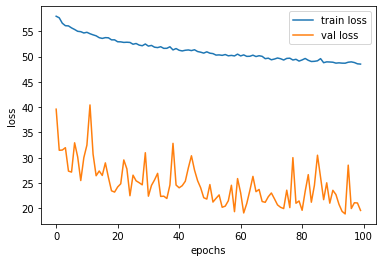

In [36]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label= 'val loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [38]:
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
# save the index of train and test set as booleans for later use
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

train_idx[:T+365] = False # First 365 values are Nan and the first T values are not predictable 

In [39]:
# Prediction -- This is one step prediction!!
train_pred = model.predict(Xtrain).flatten()
test_pred = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 19ms/step


In [46]:
df.loc[train_idx, 'Train pred of differencing'] = train_pred
df.loc[test_idx, 'Test pred of differencing'] = test_pred

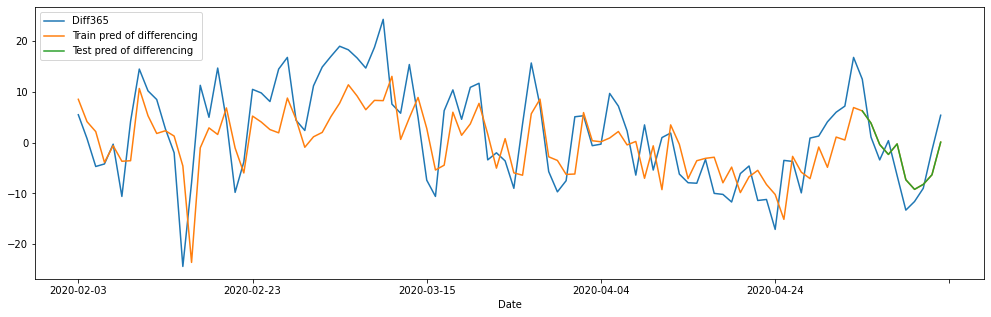

In [48]:
df[['Diff365','Train pred of differencing','Test pred of differencing']].iloc[-100:].plot(figsize=(17,5))

Now we convert the data by un-differencing to look at the prediction in the temperature data itself.

In [49]:
df['ShiftTemperature'] = df['AvgTemperature'].shift(365)
df.loc[train_idx, '1_step prediction (train)'] = df['Train pred of differencing'] + df['ShiftTemperature']
df.loc[test_idx, '1_step prediction (test)'] = df['Test pred of differencing'] + df['ShiftTemperature']

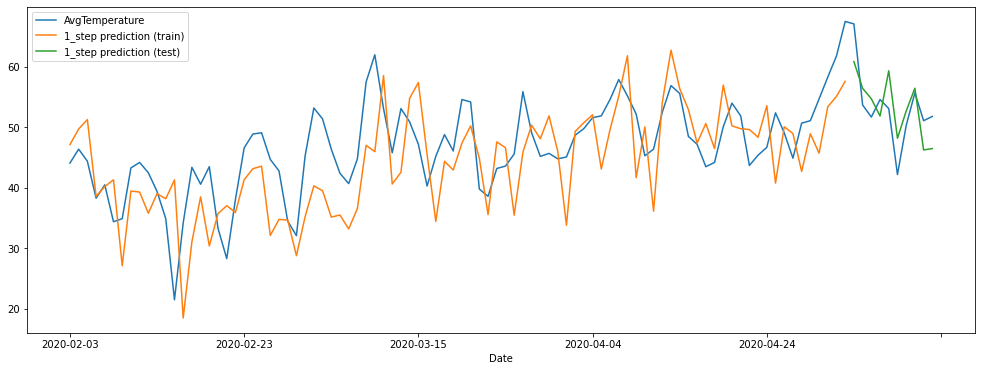

In [51]:
df[['AvgTemperature','1_step prediction (train)','1_step prediction (test)']].iloc[-100:].plot(figsize=(17,6))

Now, I do multi-step forecasting like what I did in ANN notebook. Meaning that first I predict a value then shift the data set and use the predicted value to forecast the next temperature. This way, I use the forecasted value for my next predictions. This method is more realistic than 1-step forecasting. Maybe we need to know the temperature of next week instead of knowing of the temperature of just tomorrow!

In [59]:
 Xtest[0].reshape(1,-1)

array([[-17.1,  -3.5,  -3.7,  -9.9,   0.9,   1.3,   4.1,   6. ,   7.2,
         16.8]])

In [64]:
Xtest.shape

(10, 10, 1)

In [65]:
# Multi-step prediction 

MultiStep_pred = []
features_x = Xtest[0]

while len(MultiStep_pred) < Ntest:
    p = model.predict(features_x.reshape(1,-1,1))[0]
    MultiStep_pred.append(p)
    # remove the first value in features_x and add the predicted value to the end of the list
    features_x = np.roll(features_x, -1)
    features_x[-1] = p
    

1/1 [==============================] - 0s 23ms/step


In [66]:
# Store the predicted values in the dataframe
df.loc[test_idx, 'CNN_Multistep_pred'] = MultiStep_pred

In [67]:
df.loc[test_idx, 'Multi_stepPred_test'] = df['CNN_Multistep_pred'] + df['ShiftTemperature']

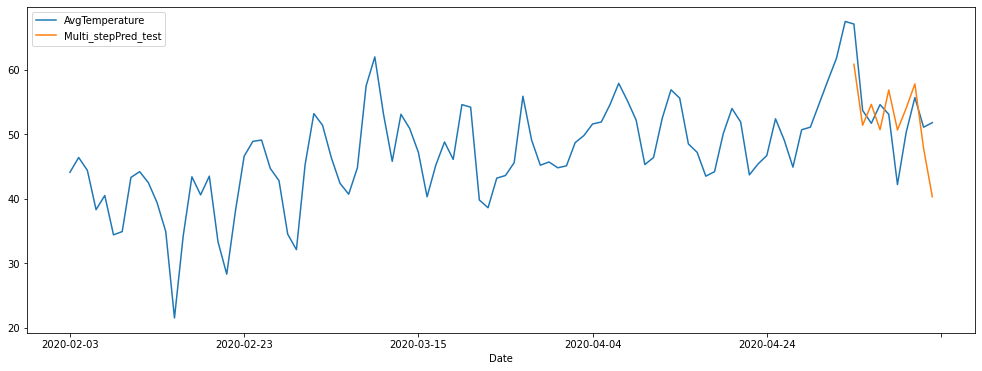

In [69]:
df[['AvgTemperature','Multi_stepPred_test']].iloc[-100:].plot(figsize=(17,6))

**It seems Multi-step forecast with CNN shows better forecasting for temperature data than ANN!**

Now I make another set of supervised data. This time, instead of predicting only just one day ahead, I use several days for as the target set.

In [70]:
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(Temperature)-Tx-Ty+1):
    x = Temperature[t:t+Tx]
    X.append(x)
    y = Temperature[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1,Tx,1)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)


In [71]:
# train-test split
Xtrain, Ytrain = X[:-1], Y[:-1]
Xtest, Ytest = X[-1:], Y[-1:]

In [72]:
# CNN model
i = Input(shape=(Tx,1))
x = Conv1D(16,3,activation='relu')(i)   # Number of feature_maps=16, fliter_size =3
x = MaxPooling1D(2)(x)
x = Conv1D(32,3,activation='relu')(x)   # Number of feature maps = 32, filter_size = 3
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i,x)


In [73]:
model.compile(loss='mse',optimizer='adam')

In [74]:
r = model.fit(Xtrain, Ytrain, epochs=200, validation_data=(Xtest, Ytest),verbose=0)

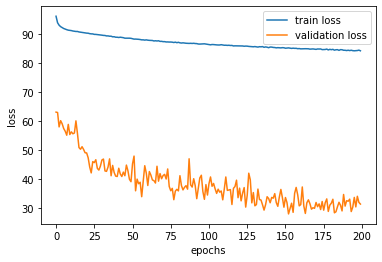

In [75]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [76]:
Train_prediction = model.predict(Xtrain)
Test_prediction = model.predict(Xtest)

1/1 [==============================] - 0s 35ms/step


In [77]:
Train_prediction = Train_prediction[:,0]
Test_prediction = Test_prediction[0]

In [78]:
df.loc[test_idx, 'predTest_10Targets'] = Test_prediction

In [79]:
df.loc[test_idx, 'Multi_targets_test'] = df['predTest_10Targets'] + df['ShiftTemperature']

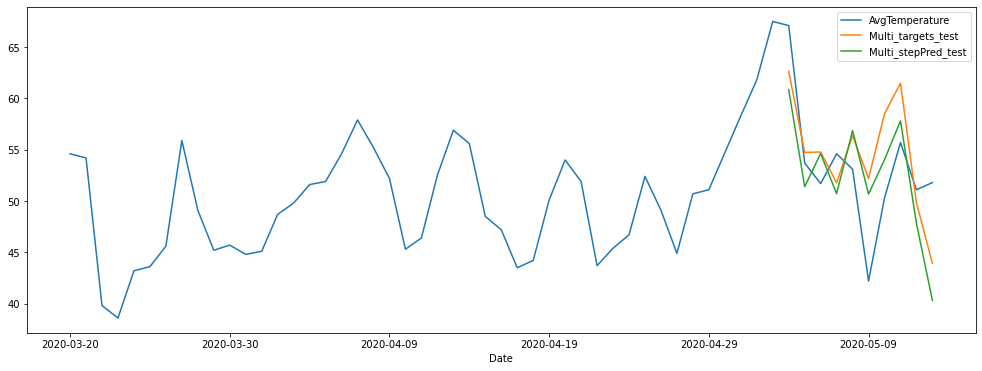

In [80]:
df[['AvgTemperature','Multi_targets_test','Multi_stepPred_test']].iloc[-55:].plot(figsize=(17,6))

**Calculate Mean Absolute Percentage Error (MAPE)**

In [82]:
MAPE_multistep_pred = mean_absolute_percentage_error(df.iloc[-Ntest:]['AvgTemperature'],df.loc[test_idx,'Multi_stepPred_test'])
MAPE_multistep_pred = mean_absolute_percentage_error(df.iloc[-Ntest:]['AvgTemperature'],df.loc[test_idx,'Multi_targets_test'])

print('MAPE_multistep_pred',MAPE_multistep_pred)
print('MAPE_multistep_pred',MAPE_multistep_pred)



MAPE_multistep_pred 0.09398654905875166
MAPE_multistep_pred 0.09398654905875166
